Code is based on https://github.com/jhuggins/viabel

In [1]:
import pickle
import pystan
import autograd.numpy as np

from viabel.objectives import (black_box_klvi,
                               black_box_chivi)

from viabel.family import (mean_field_gaussian_variational_family,
                           mean_field_t_variational_family,
                           t_variational_family)

from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import (plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction)

import pandas as pd
import time
from autograd.scipy.stats import norm

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define the model

In [2]:
test_model = """data {
  int<lower=0> N;   // number of observations
  int <lower=0> D;  // number of predictors
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}

parameters {
  vector[D] beta;        // coefficients for predictors
  real <lower=0> sigma;  // variance
}

model {
   beta ~ normal(0,1);
   sigma ~ cauchy(0, 1);
   y ~ normal(x * beta, sigma);
}"""

Generate or open existing a pkl file of the model

In [3]:
compiled_model_file = 'blr_reg_model2.pkl'

try:
    with open(compiled_model_file, 'rb') as f:
        regression_model = pickle.load(f)
except:
    regression_model = pystan.StanModel(model_code=test_model,
                                        model_name='regression_model')
    with open('blr_reg_model2.pkl', 'wb') as f:
        pickle.dump(regression_model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL regression_model_588ad05027db0a7e52c4dc6b5a415695 NOW.


Get data

In [4]:
# SYNTHETIC
# np.random.seed(1234)

# N = 1000
# D = 10
# beta_gen = np.random.randn(D, 1)
# sigma_gen = np.random.gamma(1, 1, 1)

# x = np.random.randn(N, D)
# y_raw = x.dot(beta_gen) + np.random.randn(N, 1)*np.sqrt(sigma_gen)
# y = y_raw - np.mean(y_raw)
# # convert from Nx1 matrix to Nx1 vector
# y = y.flatten()

In [5]:
#print(beta_gen)

In [6]:
#print(sigma_gen)

Import the dataset

In [7]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [8]:
y = data["Bodyfat"].values
y = y - np.mean(y)

x = data.drop("Bodyfat", axis=1)
x['Intercept'] = 1

N = x.shape[0]
D = x.shape[1]

First, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [9]:
data = dict(N=N, D=D, x=x, y=y)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [10]:
true_beta_mean = np.mean(fit['beta'], axis=0)
true_beta_cov = np.cov(fit['beta'].T)
print('true beta mean =', true_beta_mean)
print('true beta cov =', true_beta_cov)

true beta mean = [ 5.49234800e-02 -9.38161254e-02 -7.58169243e-02 -4.87358793e-01
 -1.79721999e-02  9.52791313e-01 -1.97752365e-01  2.36509892e-01
  4.50868288e-03  1.29724765e-01  1.74314432e-01  4.09046242e-01
 -1.25943477e+00 -1.30756352e-04]
true beta cov = [[ 9.93058964e-04  3.43484304e-04  2.92780413e-04 -7.56217660e-04
  -1.44549517e-04 -1.20316798e-03  3.23265362e-04  1.65019644e-03
  -1.82355278e-03  5.41325530e-04 -5.62409241e-04  1.00330733e-03
  -4.19296965e-03 -1.78939964e-05]
 [ 3.43484304e-04  2.73246468e-03 -2.40549489e-03 -3.44617507e-03
  -2.14496822e-03 -9.05288593e-04 -3.95739845e-03 -6.11679326e-04
  -2.98354856e-03 -2.02318016e-03 -1.36191927e-03 -1.56906938e-04
  -3.37585935e-03  2.07569996e-04]
 [ 2.92780413e-04 -2.40549489e-03  9.38781463e-03  4.39847904e-04
   2.27474974e-03  1.06033216e-03  3.11299580e-03  2.90325874e-03
  -1.63573379e-03  8.59862335e-04  8.05097449e-04 -1.92601417e-05
  -3.11406929e-03  1.97957286e-05]
 [-7.56217660e-04 -3.44617507e-03  4.39

In [11]:
true_sigma_mean = np.mean(fit['sigma'], axis=0)
true_sigma_cov = np.cov(fit['sigma'].T)
print('true sigma mean =', true_sigma_mean)
print('true sigma cov =', true_sigma_cov)

true sigma mean = 4.306562890387677
true sigma cov = 0.03811002655066638


In [12]:
vec1 = fit['beta']
vec2 = np.array(fit['sigma'])
vec = []
for i in range(len(vec1)):
    temp = list(np.append(vec1[i], vec2[i]))
    vec.append(temp)
vec = np.array(vec)

In [13]:
true_mean = np.mean(vec, axis=0)
true_cov = np.cov(vec.T)

In [14]:
#print('true mean =', true_mean)
#print('true cov =', true_cov)

In [15]:
fit

Inference for Stan model: regression_model_588ad05027db0a7e52c4dc6b5a415695.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]     0.05  4.6e-4   0.03 -6.1e-3   0.03   0.06   0.08   0.12   4763    1.0
beta[2]    -0.09  7.5e-4   0.05    -0.2  -0.13  -0.09  -0.06 6.7e-3   4805    1.0
beta[3]    -0.08  1.4e-3    0.1   -0.27  -0.14  -0.07  -0.01   0.11   4930    1.0
beta[4]    -0.49  3.3e-3   0.22   -0.92  -0.64  -0.49  -0.33  -0.04   4701    1.0
beta[5]    -0.02  1.4e-3    0.1   -0.21  -0.08  -0.02   0.05   0.18   4798    1.0
beta[6]     0.95  1.2e-3   0.09    0.78    0.9   0.95   1.01   1.12   4916    1.0
beta[7]     -0.2  2.0e-3   0.14   -0.47  -0.29   -0.2   -0.1   0.08   5062    1.0
beta[8]     0.24  2.1e-3   0.14   -0.04   0.14   0.23   0.33   0.51   4684    1.0
beta[9]   4.5e-3  3.3e-3   0.23   -0.45  -0.15 6.9e-3   0.16   0

# KLVI

## Mean field with Gaussian

In [16]:
# def logjointpdf(samples, x=x, y=y, D=D):
#     beta, log_sigma = samples[:, 0:D], samples[:, D]
#     mu = np.dot(x, np.transpose(beta))
    
#     lpdf = np.zeros(len(samples))

#     print("I'm here")
#     print(norm.logpdf(0,1,np.exp(log_sigma[0])))
#     for i in range(len(samples)):
#         p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#         p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, loc=0, scale=.5)
#         p3 = sum(norm.logpdf(beta[i,:], 0, 1))
                 
#         lpdf[i] = p1 + p2 + p3
     
#     return lpdf

In [17]:
# def logjointpdf(samples, x=x, y=y, D=D):
#     beta, log_sigma = samples[:, 0:D], samples[:, D]
#     mu = np.dot(x, np.transpose(beta))    
#     lpdf = []
    
#     a = .5
#     b = .5
#     for i in range(len(samples)):
#         p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#         z = np.exp(log_sigma[i])
#         p2 = -np.log(gamma(a)) - a*np.log(b) + (a-1)*np.log(z) - z/b
#         p3 = sum(norm.logpdf(beta[i,:], 0, 1))
                 
#         lpdf.append(p1 + p2 + p3)

#     return np.array(lpdf)

In [18]:
np.random.seed(123)

In [19]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)

init_mean = np.zeros(D+1)
init_log_std = np.ones(D+1)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 2000

In [20]:
stan_log_density = make_stan_log_density(fit)

In [21]:
klvi_objective_and_grad = black_box_klvi(mf_gaussian_var_family, stan_log_density, 100)

klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=1e-2)

Average Loss = 597.07: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.47it/s]


In [22]:
#plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [23]:
check_approx_accuracy(mf_gaussian_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 5.49885564e-02 -1.02264738e-01 -7.40595410e-02 -4.85292817e-01
  3.94523353e-03  9.35786148e-01 -1.62870161e-01  2.36412756e-01
  3.24393886e-04  1.12507892e-01  1.66274496e-01  3.97409199e-01
 -1.15731850e+00 -7.34844287e-04  1.51766602e+00]
stdevs = [0.0307599  0.0292248  0.08104072 0.13991899 0.05411232 0.04641417
 0.06427653 0.07800063 0.14069466 0.17977007 0.11482459 0.15467341
 0.31408842 0.27872975 0.05055093]

mean error             = 2.79
stdev error            = 0.284
||cov error||_2^{1/2}  = 0.368
||true cov||_2^{1/2}   = 0.478


In [24]:
mc_samples = 100000

samples, smoothed log weights, khat

In [25]:
klvi_samples, klvi_slw, klvi_lw, klvi_khat = \
    psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)

In [26]:
print(klvi_khat)

0.9580331201310913


In [27]:
klvi_slw

array([-79.59263778, -14.21826852, -18.04099178, ..., -19.87293674,
       -33.44803907, -12.97650058])

In [28]:
klvi_lw

array([-578.43897911, -513.06460985, -516.88733311, ..., -518.71927807,
       -532.2943804 , -511.82284191])

### VSBC diagnostics

In [29]:
# with open("./data/klvi_psis_"+str(99)+".pkl", 'rb') as f:
#     [btemp, stemp, klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp, klvi_var_param] = pickle.load(f)

In [30]:
#     def logjointpdf(samples, x=xtemp, y=y, D=D):
#         beta, log_sigma = samples[:, 0:D], samples[:, D]
#         mu = np.dot(x, np.transpose(beta))

#         lpdf = np.zeros(len(samples))
#         for i in range(len(samples)):
#             p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#             p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, 0, .5)
#             p3 = sum(norm.logpdf(beta[i,:], 0, 1))

#             lpdf[i] = p1 + p2 + p3

#         return lpdf
    
    # initialise klvi
#     def logjointpdf(x, data=xtemp, y=ytemp, D=D):
#         beta, log_sigma = x[:, 0:D], x[:, D]
#         mu = np.dot(x.values, np.transpose(beta))
        
#         obs_density = norm.logpdf(y, mu, np.exp(log_sigma))
#         sigma_density = gamma.logpdf(np.exp(log_sigma), .5, 0, .5)
#         beta_density = norm.logpdf(beta, 0, 1)
        
#         return sum(obs_density)+sum(beta_density)+sigma_density

In [31]:
M = 100
klvi_probs = np.zeros(shape=(D+1, M))

#np.random.seed(12345)
np.random.seed(100)

In [32]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = abs(np.random.standard_cauchy(1))
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    klvi_objective_and_grad_temp = black_box_klvi(mf_gaussian_var_family, stan_log_density_temp, 100)
    
    # run klvi
    klvi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, klvi_objective_and_grad_temp, init_var_param, learning_rate=.01)
    
    # store files for later
    klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp = \
        psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)
    
    with open("./data/klvi_psis_"+str(i)+".pkl", 'wb') as f:
        pickle.dump([btemp, stemp, klvi_samples_temp, klvi_slw_temp, klvi_lw_temp, klvi_khat_temp, klvi_var_param], f)
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
    
    ##################################################################
    ##################################################################
    # can remove this part and do it later with the pickled data file
    
    # extract beta mean and std
    b_mean_temp = klvi_temp_var_param[:D]
    b_std_temp = np.exp(klvi_temp_var_param[D+1:][0:D])

    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(klvi_temp_var_param, nn)

    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)

    # get the cdf values
    klvi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    klvi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
   
    ##################################################################
    ##################################################################

end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = 600.05: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 213.18it/s]


Iteration = 0, loop time = 27.819793, time elapsed = 27.819793


Average Loss = 590.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.80it/s]


Iteration = 1, loop time = 29.246843, time elapsed = 57.072642


Average Loss = 604.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 204.48it/s]


Iteration = 2, loop time = 31.237393, time elapsed = 88.316040


Average Loss = 593.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 203.77it/s]


Iteration = 3, loop time = 29.327678, time elapsed = 117.648723


Average Loss = 601.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 208.69it/s]


Iteration = 4, loop time = 29.313717, time elapsed = 146.969425


Average Loss = 601.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 205.56it/s]


Iteration = 5, loop time = 30.091425, time elapsed = 177.065855


Average Loss = 591.29: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.89it/s]


Iteration = 6, loop time = 29.394718, time elapsed = 206.466578


Average Loss = 591.9: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 191.75it/s]


Iteration = 7, loop time = 29.747037, time elapsed = 236.218620


Average Loss = 588.89: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.07it/s]


Iteration = 8, loop time = 29.255591, time elapsed = 265.480217


Average Loss = 597.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 210.69it/s]


Iteration = 9, loop time = 28.693080, time elapsed = 294.178302


Average Loss = 594.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 210.67it/s]


Iteration = 10, loop time = 29.129476, time elapsed = 323.312783


Average Loss = 584.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.89it/s]


Iteration = 11, loop time = 29.142489, time elapsed = 352.459275


Average Loss = 596.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.63it/s]


Iteration = 12, loop time = 28.813437, time elapsed = 381.277716


Average Loss = 595.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 208.06it/s]


Iteration = 13, loop time = 30.012786, time elapsed = 411.296508


Average Loss = 603.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.43it/s]


Iteration = 14, loop time = 28.973335, time elapsed = 440.273846


Average Loss = 595.35: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.05it/s]


Iteration = 15, loop time = 29.192534, time elapsed = 469.471385


Average Loss = 600.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.29it/s]


Iteration = 16, loop time = 28.122562, time elapsed = 497.598951


Average Loss = 595.3: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 211.94it/s]


Iteration = 17, loop time = 28.554188, time elapsed = 526.157143


Average Loss = 603.89: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.41it/s]


Iteration = 18, loop time = 30.126383, time elapsed = 556.288530


Average Loss = 597: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 208.17it/s]


Iteration = 19, loop time = 29.297403, time elapsed = 585.590937


Average Loss = 604.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 197.44it/s]


Iteration = 20, loop time = 30.773027, time elapsed = 616.368968


Average Loss = 595: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.19it/s]


Iteration = 21, loop time = 30.112463, time elapsed = 646.487437


Average Loss = 600.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 213.44it/s]


Iteration = 22, loop time = 28.565965, time elapsed = 675.058406


Average Loss = 596.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 223.04it/s]


Iteration = 23, loop time = 28.666055, time elapsed = 703.729466


Average Loss = 590.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 222.49it/s]


Iteration = 24, loop time = 28.344764, time elapsed = 732.079234


Average Loss = 595.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.55it/s]


Iteration = 25, loop time = 28.918285, time elapsed = 761.003524


Average Loss = 591.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.14it/s]


Iteration = 26, loop time = 28.330750, time elapsed = 789.340280


Average Loss = 604.74: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.36it/s]


Iteration = 27, loop time = 28.016971, time elapsed = 817.362256


Average Loss = 595.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 222.04it/s]


Iteration = 28, loop time = 28.361778, time elapsed = 845.729039


Average Loss = 594.01: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.45it/s]


Iteration = 29, loop time = 28.085528, time elapsed = 873.819572


Average Loss = 609.17: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.91it/s]


Iteration = 30, loop time = 29.421746, time elapsed = 903.246323


Average Loss = 587.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.17it/s]


Iteration = 31, loop time = 28.996356, time elapsed = 932.246683


Average Loss = 593.15: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.67it/s]


Iteration = 32, loop time = 28.461869, time elapsed = 960.713557


Average Loss = 600.62: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.72it/s]


Iteration = 33, loop time = 28.982343, time elapsed = 989.700904


Average Loss = 594.35: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.80it/s]


Iteration = 34, loop time = 28.377794, time elapsed = 1018.083702


Average Loss = 607.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.24it/s]


Iteration = 35, loop time = 28.542943, time elapsed = 1046.631650


Average Loss = 594.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 197.49it/s]


Iteration = 36, loop time = 29.574764, time elapsed = 1076.211419


Average Loss = 580.94: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.52it/s]


Iteration = 37, loop time = 29.154499, time elapsed = 1105.370921


Average Loss = 599.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.21it/s]


Iteration = 38, loop time = 28.303726, time elapsed = 1133.679651


Average Loss = 601.31: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.63it/s]


Iteration = 39, loop time = 28.466875, time elapsed = 1162.151530


Average Loss = 606.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.77it/s]


Iteration = 40, loop time = 28.948437, time elapsed = 1191.105973


Average Loss = 592.74: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 222.12it/s]


Iteration = 41, loop time = 28.328253, time elapsed = 1219.439231


Average Loss = 589.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.39it/s]


Iteration = 42, loop time = 28.446574, time elapsed = 1247.890809


Average Loss = 589.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.65it/s]


Iteration = 43, loop time = 28.266693, time elapsed = 1276.162506


Average Loss = 595.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.96it/s]


Iteration = 44, loop time = 29.055409, time elapsed = 1305.223921


Average Loss = 593.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 212.78it/s]


Iteration = 45, loop time = 30.117633, time elapsed = 1335.347560


Average Loss = 586.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 201.63it/s]


Iteration = 46, loop time = 29.410732, time elapsed = 1364.763296


Average Loss = 595.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.87it/s]


Iteration = 47, loop time = 28.948312, time elapsed = 1393.716613


Average Loss = 596.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.33it/s]


Iteration = 48, loop time = 27.559049, time elapsed = 1421.280667


Average Loss = 599.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.43it/s]


Iteration = 49, loop time = 28.861234, time elapsed = 1450.147907


Average Loss = 606.7: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.32it/s]


Iteration = 50, loop time = 28.891259, time elapsed = 1479.044172


Average Loss = 581.17: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.43it/s]


Iteration = 51, loop time = 28.117557, time elapsed = 1507.166733


Average Loss = 604.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 205.66it/s]


Iteration = 52, loop time = 29.106454, time elapsed = 1536.278193


Average Loss = 594.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.91it/s]


Iteration = 53, loop time = 28.237665, time elapsed = 1564.520864


Average Loss = 590.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.94it/s]


Iteration = 54, loop time = 28.779157, time elapsed = 1593.306028


Average Loss = 605.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.16it/s]


Iteration = 55, loop time = 28.637030, time elapsed = 1621.950063


Average Loss = 591.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.11it/s]


Iteration = 56, loop time = 28.173608, time elapsed = 1650.128676


Average Loss = 600.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.64it/s]


Iteration = 57, loop time = 28.053499, time elapsed = 1678.187179


Average Loss = 612.25: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.01it/s]


Iteration = 58, loop time = 29.005965, time elapsed = 1707.199149


Average Loss = 620.29: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.56it/s]


Iteration = 59, loop time = 27.762967, time elapsed = 1734.967122


Average Loss = 600.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 215.53it/s]


Iteration = 60, loop time = 29.843949, time elapsed = 1764.816075


Average Loss = 587.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.95it/s]


Iteration = 61, loop time = 28.325746, time elapsed = 1793.146826


Average Loss = 602.29: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.21it/s]


Iteration = 62, loop time = 27.398908, time elapsed = 1820.550739


Average Loss = 595.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.24it/s]


Iteration = 63, loop time = 27.928385, time elapsed = 1848.484123


Average Loss = 607.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.45it/s]


Iteration = 64, loop time = 27.768240, time elapsed = 1876.256366


Average Loss = 601.05: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.80it/s]


Iteration = 65, loop time = 28.276703, time elapsed = 1904.538073


Average Loss = 593.89: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.01it/s]


Iteration = 66, loop time = 28.407821, time elapsed = 1932.951899


Average Loss = 594.17: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 217.74it/s]


Iteration = 67, loop time = 27.619104, time elapsed = 1960.576008


Average Loss = 598.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.24it/s]


Iteration = 68, loop time = 27.702180, time elapsed = 1988.282191


Average Loss = 589.58: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 201.55it/s]


Iteration = 69, loop time = 28.034482, time elapsed = 2016.321677


Average Loss = 594.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.06it/s]


Iteration = 70, loop time = 29.257593, time elapsed = 2045.584275


Average Loss = 591.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.41it/s]


Iteration = 71, loop time = 27.587075, time elapsed = 2073.176353


Average Loss = 598.15: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.44it/s]


Iteration = 72, loop time = 28.154591, time elapsed = 2101.334948


Average Loss = 595.14: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.48it/s]


Iteration = 73, loop time = 27.734209, time elapsed = 2129.074161


Average Loss = 602.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.69it/s]


Iteration = 74, loop time = 27.532025, time elapsed = 2156.611190


Average Loss = 590.89: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 203.36it/s]


Iteration = 75, loop time = 29.098450, time elapsed = 2185.714645


Average Loss = 593.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.86it/s]


Iteration = 76, loop time = 27.980432, time elapsed = 2213.700080


Average Loss = 607.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.21it/s]


Iteration = 77, loop time = 27.825292, time elapsed = 2241.530376


Average Loss = 600.01: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.97it/s]


Iteration = 78, loop time = 28.841214, time elapsed = 2270.376595


Average Loss = 594.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.19it/s]


Iteration = 79, loop time = 27.646130, time elapsed = 2298.027729


Average Loss = 583.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.75it/s]


Iteration = 80, loop time = 28.388803, time elapsed = 2326.421537


Average Loss = 599.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.04it/s]


Iteration = 81, loop time = 28.418831, time elapsed = 2354.847374


Average Loss = 586.68: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.53it/s]


Iteration = 82, loop time = 27.928385, time elapsed = 2382.782765


Average Loss = 593.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.11it/s]


Iteration = 83, loop time = 27.893355, time elapsed = 2410.682125


Average Loss = 603.03: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.29it/s]


Iteration = 84, loop time = 28.374789, time elapsed = 2439.061919


Average Loss = 610.42: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.12it/s]


Iteration = 85, loop time = 27.724200, time elapsed = 2466.791123


Average Loss = 594.01: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.02it/s]


Iteration = 86, loop time = 27.554045, time elapsed = 2494.350173


Average Loss = 606.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.89it/s]


Iteration = 87, loop time = 27.675154, time elapsed = 2522.030332


Average Loss = 606.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.23it/s]


Iteration = 88, loop time = 27.874336, time elapsed = 2549.909672


Average Loss = 588.99: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.74it/s]


Iteration = 89, loop time = 27.168695, time elapsed = 2577.083372


Average Loss = 603.29: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.91it/s]


Iteration = 90, loop time = 28.105546, time elapsed = 2605.193923


Average Loss = 588.84: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 197.82it/s]


Iteration = 91, loop time = 28.797175, time elapsed = 2633.996102


Average Loss = 595.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.92it/s]


Iteration = 92, loop time = 27.572312, time elapsed = 2661.573419


Average Loss = 610.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.24it/s]


Iteration = 93, loop time = 27.923380, time elapsed = 2689.501804


Average Loss = 585.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.45it/s]


Iteration = 94, loop time = 28.168603, time elapsed = 2717.675412


Average Loss = 591.35: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.15it/s]


Iteration = 95, loop time = 28.165599, time elapsed = 2745.847018


Average Loss = 595.58: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.26it/s]


Iteration = 96, loop time = 28.615010, time elapsed = 2774.467032


Average Loss = 591.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.60it/s]


Iteration = 97, loop time = 27.499996, time elapsed = 2801.972032


Average Loss = 594.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.17it/s]


Iteration = 98, loop time = 28.475883, time elapsed = 2830.452919


Average Loss = 604.7: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.07it/s]


Iteration = 99, loop time = 28.706092, time elapsed = 2859.164016
Total time taken: 2859.169021


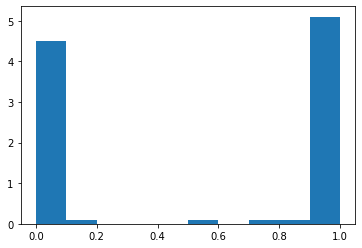

In [33]:
plt.hist(klvi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

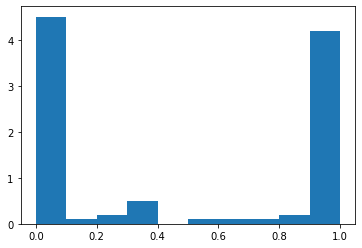

In [34]:
plt.hist(klvi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

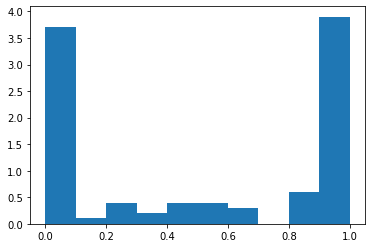

In [35]:
plt.hist(klvi_probs[D-1,:], bins=10, density=True, range=(0,1))
plt.show()

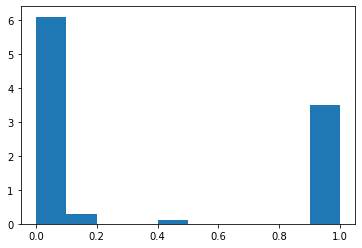

In [36]:
plt.hist(klvi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [37]:
np.savetxt("./data/klvi_probs.csv", klvi_probs, delimiter=",")

## CHIVI Mean field with Gaussian

In [38]:
# init_mean = np.zeros(D+1)
# init_log_std = np.ones(D+1)
# init_var_param = np.concatenate([init_mean, init_log_std])
# n_iters = 2000

In [39]:
init_var_param = klvi_var_param.copy()
n_iters = 2000

In [40]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)
chivi_objective_and_grad = black_box_chivi(2, mf_gaussian_var_family, stan_log_density, 200)

chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=5e-4)

Average Loss = -513.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.27it/s]


In [41]:
#plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

In [42]:
check_approx_accuracy(mf_gaussian_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.01224939 -0.09430025 -0.05768824 -0.48440438  0.00906277  0.91581704
 -0.13842648  0.24952488  0.00802292  0.12487666  0.16811879  0.39973047
 -1.1444589  -0.00545838  1.70330666]
stdevs = [0.03075883 0.02893284 0.08083809 0.13760574 0.05346249 0.04578175
 0.06307039 0.07665077 0.13848163 0.17852189 0.11393442 0.15356388
 0.30993853 0.27898641 0.04631476]

mean error             = 2.61
stdev error            = 0.292
||cov error||_2^{1/2}  = 0.371
||true cov||_2^{1/2}   = 0.478


In [43]:
mc_samples=100000

In [44]:
chivi_samples, chivi_slw, chivi_lw, chivi_khat = \
    psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)

In [45]:
print(chivi_khat)

2.0833478695851846


In [46]:
chivi_slw

array([-49.8305126 , -30.60091653, -23.14049087, ..., -25.44780351,
       -29.48745228, -28.55744728])

In [47]:
chivi_lw

array([-552.39841027, -533.1688142 , -525.70838855, ..., -528.01570119,
       -532.05534996, -531.12534496])

### VSBC diagnostics

In [48]:
M = 100
chivi_probs = np.zeros(shape=(D+1, M))
n_iters = 2000

#np.random.seed(123)
np.random.seed(100)

In [49]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior    
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = abs(np.random.standard_cauchy(1))
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    chivi_objective_and_grad_temp = black_box_chivi(2, mf_gaussian_var_family, stan_log_density_temp, 200)
    
    init_var_param = klvi_temp_var_param.copy()
    # run chivi
    chivi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, chivi_objective_and_grad_temp, init_var_param, learning_rate=5e-4)
    
    # store files for later
    chivi_samples_temp, chivi_slw_temp, chivi_lw_temp, chivi_khat_temp = \
        psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)
    
    with open("./data/chivi_psis_"+str(i)+".pkl", 'wb') as f:
        pickle.dump([btemp, stemp, chivi_samples_temp, chivi_slw_temp, chivi_lw_temp, chivi_khat_temp, chivi_var_param], f)
    
    
    ##################################################################
    ##################################################################
    # can remove this part and do it later with the pickled data file
    
    # extract beta mean and std
    b_mean_temp = chivi_temp_var_param[:D]
    b_std_temp = np.exp(chivi_temp_var_param[D+1:][0:D])
    
    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(chivi_temp_var_param, nn)
    
    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)
    
    # get the cdf values
    chivi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    chivi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
    
    ##################################################################
    ##################################################################
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = -513.53: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.28it/s]


Iteration = 0, loop time = 50.531637, time elapsed = 50.531637


Average Loss = -515.58: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.79it/s]


Iteration = 1, loop time = 47.877517, time elapsed = 98.410155


Average Loss = -514.26: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.38it/s]


Iteration = 2, loop time = 47.862504, time elapsed = 146.272659


Average Loss = -520.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.56it/s]


Iteration = 3, loop time = 47.409092, time elapsed = 193.682753


Average Loss = -513.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.47it/s]


Iteration = 4, loop time = 46.788527, time elapsed = 240.471280


Average Loss = -514.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.46it/s]


Iteration = 5, loop time = 47.127094, time elapsed = 287.599375


Average Loss = -514.6: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.64it/s]


Iteration = 6, loop time = 47.607271, time elapsed = 335.207647


Average Loss = -514.17: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 66.49it/s]


Iteration = 7, loop time = 49.427941, time elapsed = 384.636589


Average Loss = -513.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.44it/s]


Iteration = 8, loop time = 46.952679, time elapsed = 431.589268


Average Loss = -514.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.47it/s]


Iteration = 9, loop time = 46.500263, time elapsed = 478.089531


Average Loss = -517.26: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.21it/s]


Iteration = 10, loop time = 46.287072, time elapsed = 524.376603


Average Loss = -515.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.80it/s]


Iteration = 11, loop time = 48.388983, time elapsed = 572.765586


Average Loss = -513.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.55it/s]


Iteration = 12, loop time = 47.434114, time elapsed = 620.199700


Average Loss = -513.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.96it/s]


Iteration = 13, loop time = 47.109820, time elapsed = 667.309520


Average Loss = -514: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.03it/s]


Iteration = 14, loop time = 46.978700, time elapsed = 714.289221


Average Loss = -512.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.53it/s]


Iteration = 15, loop time = 47.247946, time elapsed = 761.537167


Average Loss = -514.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.28it/s]


Iteration = 16, loop time = 46.933659, time elapsed = 808.470825


Average Loss = -513.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.05it/s]


Iteration = 17, loop time = 47.106821, time elapsed = 855.577646


Average Loss = -513.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.60it/s]


Iteration = 18, loop time = 46.772513, time elapsed = 902.351160


Average Loss = -513.89: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.22it/s]


Iteration = 19, loop time = 46.638411, time elapsed = 948.989571


Average Loss = -513.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.41it/s]


Iteration = 20, loop time = 47.691349, time elapsed = 996.681920


Average Loss = -513.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.43it/s]


Iteration = 21, loop time = 47.128837, time elapsed = 1043.811758


Average Loss = -513.24: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.23it/s]


Iteration = 22, loop time = 47.421103, time elapsed = 1091.232861


Average Loss = -513.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.45it/s]


Iteration = 23, loop time = 46.730475, time elapsed = 1137.963336


Average Loss = -513.6: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.33it/s]


Iteration = 24, loop time = 48.476060, time elapsed = 1186.440398


Average Loss = -514.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.28it/s]


Iteration = 25, loop time = 47.024743, time elapsed = 1233.465141


Average Loss = -514.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.30it/s]


Iteration = 26, loop time = 46.963686, time elapsed = 1280.428827


Average Loss = -514.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.46it/s]


Iteration = 27, loop time = 47.161867, time elapsed = 1327.590694


Average Loss = -514.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.80it/s]


Iteration = 28, loop time = 48.019646, time elapsed = 1375.611341


Average Loss = -514.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.13it/s]


Iteration = 29, loop time = 47.907545, time elapsed = 1423.518886


Average Loss = -513.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.32it/s]


Iteration = 30, loop time = 47.053768, time elapsed = 1470.573656


Average Loss = -515.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.92it/s]


Iteration = 31, loop time = 50.536936, time elapsed = 1521.111592


Average Loss = -513.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.97it/s]


Iteration = 32, loop time = 47.211936, time elapsed = 1568.323528


Average Loss = -513.94: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.21it/s]


Iteration = 33, loop time = 47.424105, time elapsed = 1615.747633


Average Loss = -513.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.51it/s]


Iteration = 34, loop time = 47.463141, time elapsed = 1663.210775


Average Loss = -515.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.85it/s]


Iteration = 35, loop time = 46.997717, time elapsed = 1710.209493


Average Loss = -513.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.38it/s]


Iteration = 36, loop time = 47.441122, time elapsed = 1757.650614


Average Loss = -514.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.99it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration = 37, loop time = 47.391074, time elapsed = 1805.042690


Average Loss = -518.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.78it/s]


Iteration = 38, loop time = 50.643031, time elapsed = 1855.685721


Average Loss = -513.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.22it/s]


Iteration = 39, loop time = 47.340029, time elapsed = 1903.025750


Average Loss = -515.24: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.02it/s]


Iteration = 40, loop time = 47.773422, time elapsed = 1950.799173


Average Loss = -514.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.29it/s]


Iteration = 41, loop time = 47.570239, time elapsed = 1998.369412


Average Loss = -517.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.56it/s]


Iteration = 42, loop time = 47.092804, time elapsed = 2045.462216


Average Loss = -513.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.66it/s]


Iteration = 43, loop time = 46.365143, time elapsed = 2091.828360


Average Loss = -514.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.96it/s]


Iteration = 44, loop time = 48.119737, time elapsed = 2139.948097


Average Loss = -514.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.29it/s]


Iteration = 45, loop time = 47.930566, time elapsed = 2187.878663


Average Loss = -514.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.96it/s]


Iteration = 46, loop time = 47.074788, time elapsed = 2234.953450


Average Loss = -514.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.97it/s]


Iteration = 47, loop time = 47.666326, time elapsed = 2282.619776


Average Loss = -513.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.64it/s]


Iteration = 48, loop time = 47.448128, time elapsed = 2330.068904


Average Loss = -516.19: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.26it/s]


Iteration = 49, loop time = 47.603268, time elapsed = 2377.672172


Average Loss = -513.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.42it/s]


Iteration = 50, loop time = 47.150858, time elapsed = 2424.823030


Average Loss = -514.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.20it/s]


Iteration = 51, loop time = 47.731384, time elapsed = 2472.554414


Average Loss = -513.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.43it/s]


Iteration = 52, loop time = 47.641302, time elapsed = 2520.196717


Average Loss = -517.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.86it/s]


Iteration = 53, loop time = 47.505824, time elapsed = 2567.703543


Average Loss = -513.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.99it/s]


Iteration = 54, loop time = 51.853022, time elapsed = 2619.556565


Average Loss = -513.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.67it/s]


Iteration = 55, loop time = 49.392895, time elapsed = 2668.950461


Average Loss = -513.77: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.99it/s]


Iteration = 56, loop time = 48.171904, time elapsed = 2717.122364


Average Loss = -513.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.59it/s]


Iteration = 57, loop time = 48.469205, time elapsed = 2765.591569


Average Loss = -513.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.04it/s]


Iteration = 58, loop time = 48.192753, time elapsed = 2813.784322


Average Loss = -513.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.47it/s]


Iteration = 59, loop time = 47.257340, time elapsed = 2861.041661


Average Loss = -513.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.04it/s]


Iteration = 60, loop time = 47.954856, time elapsed = 2908.997518


Average Loss = -515.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.55it/s]


Iteration = 61, loop time = 47.562231, time elapsed = 2956.560750


Average Loss = -514.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.80it/s]


Iteration = 62, loop time = 47.340434, time elapsed = 3003.901184


Average Loss = -513.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.54it/s]


Iteration = 63, loop time = 55.489620, time elapsed = 3059.391805


Average Loss = -514.74: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.73it/s]


Iteration = 64, loop time = 51.550141, time elapsed = 3110.942947


Average Loss = -513.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.06it/s]


Iteration = 65, loop time = 51.140229, time elapsed = 3162.084177


Average Loss = -514.09: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.17it/s]


Iteration = 66, loop time = 51.142910, time elapsed = 3213.228087


Average Loss = -513.78: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.39it/s]


Iteration = 67, loop time = 53.277927, time elapsed = 3266.506014


Average Loss = -514.4: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.42it/s]


Iteration = 68, loop time = 52.210737, time elapsed = 3318.717752


Average Loss = -514.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.11it/s]


Iteration = 69, loop time = 52.261819, time elapsed = 3370.980572


Average Loss = -513.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.55it/s]


Iteration = 70, loop time = 53.369777, time elapsed = 3424.350349


Average Loss = -515.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.50it/s]


Iteration = 71, loop time = 52.120374, time elapsed = 3476.470723


Average Loss = -513.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.41it/s]


Iteration = 72, loop time = 54.354950, time elapsed = 3530.825673


Average Loss = -513.74: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.59it/s]


Iteration = 73, loop time = 52.642680, time elapsed = 3583.468353


Average Loss = -514.02: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.67it/s]


Iteration = 74, loop time = 51.683528, time elapsed = 3635.151881


Average Loss = -513.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.42it/s]


Iteration = 75, loop time = 52.538048, time elapsed = 3687.689929


Average Loss = -513.36: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.55it/s]


Iteration = 76, loop time = 51.171606, time elapsed = 3738.861535


Average Loss = -513.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.93it/s]


Iteration = 77, loop time = 52.727385, time elapsed = 3791.589921


Average Loss = -514.05: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 55.77it/s]


Iteration = 78, loop time = 57.372335, time elapsed = 3848.962257


Average Loss = -513.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.81it/s]


Iteration = 79, loop time = 51.874896, time elapsed = 3900.837153


Average Loss = -514.19: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.59it/s]


Iteration = 80, loop time = 50.562294, time elapsed = 3951.400448


Average Loss = -515.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.04it/s]


Iteration = 81, loop time = 51.471315, time elapsed = 4002.872764


Average Loss = -514.58: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.87it/s]


Iteration = 82, loop time = 51.005347, time elapsed = 4053.878110


Average Loss = -513.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.91it/s]


Iteration = 83, loop time = 50.302752, time elapsed = 4104.180862


Average Loss = -515.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.11it/s]


Iteration = 84, loop time = 50.021742, time elapsed = 4154.203605


Average Loss = -514.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.90it/s]


Iteration = 85, loop time = 51.784717, time elapsed = 4205.989323


Average Loss = -513.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.50it/s]


Iteration = 86, loop time = 57.432662, time elapsed = 4263.421986


Average Loss = -513.75: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.31it/s]


Iteration = 87, loop time = 52.177261, time elapsed = 4315.599246


Average Loss = -513.03: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.80it/s]


Iteration = 88, loop time = 50.998254, time elapsed = 4366.598502


Average Loss = -513.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.51it/s]


Iteration = 89, loop time = 51.771689, time elapsed = 4418.370191


Average Loss = -514.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.05it/s]


Iteration = 90, loop time = 54.372306, time elapsed = 4472.743498


Average Loss = -513.82: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.74it/s]


Iteration = 91, loop time = 52.200850, time elapsed = 4524.944348


Average Loss = -513.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.17it/s]


Iteration = 92, loop time = 51.605730, time elapsed = 4576.550078


Average Loss = -513.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.42it/s]


Iteration = 93, loop time = 51.457272, time elapsed = 4628.007350


Average Loss = -513.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.81it/s]


Iteration = 94, loop time = 51.818455, time elapsed = 4679.825805


Average Loss = -513.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.98it/s]


Iteration = 95, loop time = 51.417348, time elapsed = 4731.243154


Average Loss = -516.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.20it/s]


Iteration = 96, loop time = 51.200664, time elapsed = 4782.443818


Average Loss = -515.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.08it/s]


Iteration = 97, loop time = 52.769781, time elapsed = 4835.213599


Average Loss = -515.82: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 60.36it/s]


Iteration = 98, loop time = 54.855302, time elapsed = 4890.069902


Average Loss = -514.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.35it/s]


Iteration = 99, loop time = 51.526328, time elapsed = 4941.597231
Total time taken: 4941.597231


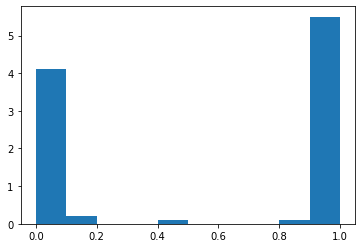

In [50]:
plt.hist(chivi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

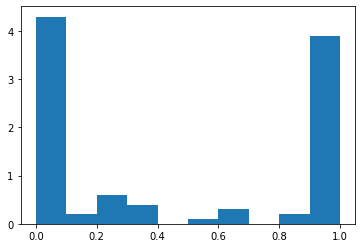

In [51]:
plt.hist(chivi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

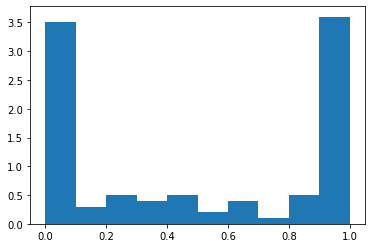

In [52]:
plt.hist(chivi_probs[D-1,:], bins=10, density=True, range=(0,1))
plt.show()

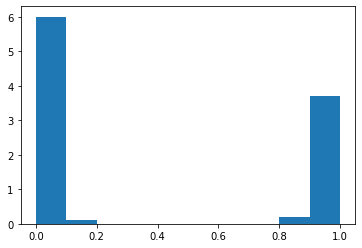

In [53]:
plt.hist(chivi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [54]:
np.savetxt("./data/chivi_probs.csv", chivi_probs, delimiter=",")

# Misc: testing other algorithms

## KLVI Non-mean field full-rank 

In [55]:
t_var_family = t_variational_family(D+1, 100)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)

full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

Average Loss = 531.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 142.34it/s]


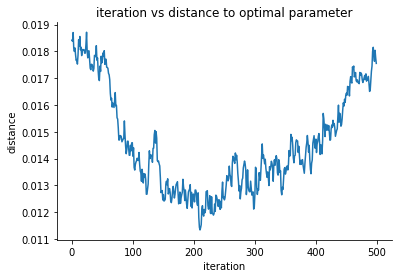

In [56]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

In [57]:
full_klvi_samples, full_klvi_slw, full_klvi_lw, full_klvi_khat = \
    psis_correction(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)

In [58]:
print(full_klvi_khat)

0.10309314857385614


In [59]:
full_klvi_slw

array([-11.35994749, -11.05446047, -11.30832023, ..., -11.49671793,
       -11.84537894, -11.41605186])

In [60]:
full_klvi_lw

array([-509.6775712 , -509.37208418, -509.62594394, ..., -509.81434164,
       -510.16300265, -509.73367557])

## KLVI Mean field with t distribution (df=40)

In [58]:
# mf_t_var_family = mean_field_t_variational_family(D+1, 40)
# klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

# klvi_t_var_param, klvi_t_param_history, klvi_t_history, _ = \
#     adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

In [59]:
#plot_dist_to_opt_param(klvi_t_param_history, klvi_t_var_param)

In [60]:
#check_approx_accuracy(mf_t_var_family, klvi_t_var_param, true_mean, true_cov, verbose=True);

In [61]:
#klvi_t_samples, klvi_t_slw, klvi_t_khat = \
#    psis_correction(stan_log_density, mf_t_var_family, klvi_t_var_param, mc_samples)

In [62]:
#print(klvi_t_khat)

In [63]:
#klvi_t_slw

## CHIVI Mean field with t distribution (df=40)

In [64]:
# mf_t_var_family = mean_field_t_variational_family(D+1, 40)
# chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 400)

# init_var_param = klvi_var_param.copy()
# init_var_param[2:] += 3

# chivi_t_var_param, chivi_t_param_history, chivi_t_history, _ = \
#     adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

In [65]:
# plot_dist_to_opt_param(chivi_t_param_history, chivi_t_var_param)

In [66]:
# chivi_t_samples, chivi_t_slw, chivi_t_khat = \
#     psis_correction(stan_log_density, mf_t_var_family, chivi_t_var_param, mc_samples)

In [67]:
# print(chivi_t_khat)

In [68]:
# chivi_t_slw

### CHIVI full rank

In [69]:
# t_var_family = t_variational_family(D+1, 100)
# full_chivi_objective_and_grad = black_box_chivi(2, t_var_family, stan_log_density, 400)

# init_var_param = full_klvi_var_param.copy()
# init_var_param[2:] += 3

# full_chivi_var_param, full_chivi_param_history, full_chivi_history, _ = \
#     adagrad_optimize(n_iters, full_chivi_objective_and_grad, init_var_param, 
#                      learning_rate=.1, learning_rate_end=.001)

In [70]:
#plot_dist_to_opt_param(full_chivi_param_history, full_chivi_var_param)

In [71]:
#full_chivi_samples, full_chivi_slw, full_chivi_khat = \
#    psis_correction(stan_log_density, t_var_family, full_chivi_var_param, mc_samples)

In [72]:
#print(full_chivi_khat)

In [73]:
#full_chivi_slw